# Fitting a Parametric Model with a Parametric Class of Distributions

## Introduction
In these notebooks, we show how to use SVI to fit non-parametric models with a parametric class of models. This is useful if we have little prior knowledge of the *true model* that describes an underlying process, but we can use non-parametric models to make predictions regarding the process given available data. Such a technique of *translating* a non-parametric model to a parametric model would be useful for assessing the performance of interpretable (or physical) models.

In this notebook, we start with a simpler problem. Instead of fitting a parametric distribution to a non-parametric distribution, we start with a much simpler problem: fitting a parametric distribution with a parametric class of distributions. Moreover, we include the true distribution in the class of models.

## Fitting Distributions by Minimizing Analytic KL-Divergence
Let $q(x)$ denote the true distribution to be approximated by $p_{\phi}(x)$.
\begin{equation}
 \left\{\begin{matrix} q(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-(x-\mu)^2 / 2 \sigma^2}
 \\ p_{\phi}(x) = \frac{1}{\sqrt{2 \pi \Sigma^2}} e^{-(x-m)^2 / 2 \Sigma^2}.
\end{matrix}\right.
\end{equation}
Here, $(\mu, \sigma)$ are fixed and $\phi = (m , \Sigma)$ are fitting hyperparameters. 

The similarity between $q$ and $p_{\phi}$ is given by the KL-divergence:
$$ KL[q(x) || p_{\phi}(x)] = \mathbb{E}_{q}[\log q(x) - \log p_{\phi}(x)], $$
where higher similarity corresponds to lower values in the KL-divergence.
Therefore, the fit distribution $p_{\phi}$ that best approximates $q$ possesses the hyperparameter $\phi^{*}$, given by
$$ \phi^{*} = \mathrm{argmin}_{\phi} KL = \mathrm{argmin}_{\phi} \mathbb{E}_{q}[-\log p_{\phi}(x)], $$
where
$$ \mathbb{E}_{q}[-\log p_{\phi}(x)] = \frac{1}{2}\frac{[(m - \mu)^{2} + \sigma^{2}]}{\Sigma^{2}} + \log \Sigma + \log \sqrt{2 \pi}. $$

In this case, we can solve for $\phi^{*}$ analytically. Letting $\mathcal{L}$ be the non-constant part of the above expression, we can associate $\phi^{*}$ with a critical point of $\mathcal{L}$. For example, intuiting that the minimum corresponds to $\mu = m$, we find the optimal $\Sigma$ by taking the first-derivative in $\Sigma$:
$$ 
\begin{aligned}
  0 = \frac{\partial \mathcal{L}}{\partial \Sigma} & = -\frac{[(m - \mu)^{2} + \sigma^{2}]}{\Sigma^3} + \frac{1}{\Sigma} \\
  & \sim -[(m - \mu)^{2} + \sigma^{2}] + \Sigma^2  \\
  & \sim -\sigma^2 + \Sigma^2
\end{aligned},
$$
Therefore, the KL-divergence has a critical point at $(m,\Sigma) = (\mu, \sigma)$. One can further prove this is the minimum, which means we found the $p_{\phi}$ that best approximates $q$.

## Numerical Optimization with `SciPy`
Suppose we can calculate $q(x)$ and $p_{\phi}(x)$, but the KL-divergence has no known closed-form expression. Then, a simple method of numerical optimization is possible if we can sample from the *true* distribution $q$. We can approximate the objective as follows:
$$ \mathbb{E}_{q}[-\log p_{\phi}(x)] \sim -\sum_{i=1}^{N} \ \log p_{\phi}(x_{i}), $$
where $x_{i} \sim q$. Since the problem is now a stochastic optimization problem, we cannot use standard gradient-descent algorithms out-of-the-box. Instead, we opt for a non-gradient based technique: the `Powell` method. We perform this below with `SciPy`.

### Example I: Fitting a Standard Normal Distribution with a Class of Normal Distributions
#### Define approximate KL-divergence

In [1]:
from scipy.optimize import minimize # for function minimization
from scipy.stats import norm # for normal distribution
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting

# sample-average approximation to KL-divergence
def objective_fn(x, args):
    mu_p, s_p = x # mu, sigma of fit distribution
    mu_q, s_q, num_samples = args # mu, sigma of target distribution, number of samples
    s_p = abs(s_p) ; s_q = abs(s_q) # ensure positive standard deviations
    q_samples = norm.rvs(mu_q, s_q, num_samples) # sample from target distribution
    return np.mean(norm.logpdf(q_samples, mu_q, s_q) - norm.logpdf(q_samples, mu_p, s_p)) # approximate KL-divergence

#### Verify Graphically that Minimum KL Corresponds to $(m, \Sigma) = (\mu, \sigma)$

Text(0, 0.5, 'KL')

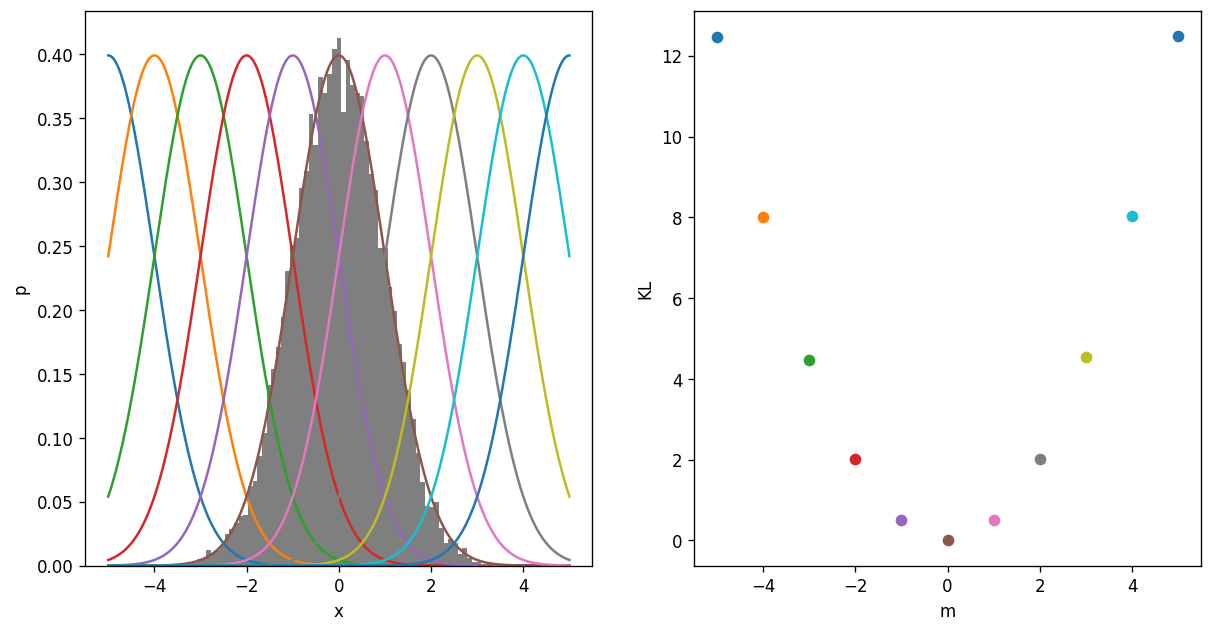

In [2]:
# load standard normal distribution (q)
norm_q = norm(0., 1.) 

# plot several displaced normal distributions (p_phi)
x = np.linspace(-5,5,1000)
m_list = np.linspace(-5,5,11)
Nm = len(m_list)

# plot the distributions and the KL-divergence
fig = plt.figure(figsize=(12, 6), dpi= 120)
ax1 = fig.add_subplot(121) ; ax2 = fig.add_subplot(122)
q_samples = norm_q.rvs(10000)
ax1.hist(q_samples, np.linspace(-5,5,100), density = True, color = 'k', alpha = 0.5)
    
c_id = 0 # color id
for nm in range(Nm):
    m = m_list[nm]
    norm_p = norm(m, 1.)
    log_q = norm_q.logpdf
    log_p = norm_p.logpdf
    ax1.plot(x, np.exp(log_p(x)), color = "C" + str(c_id))
    ax2.scatter(m, objective_fn([m, 1.], [0., 1., 10000]), color = "C" + str(c_id))
    c_id += 1
    
ax1.set_xlabel('x')
ax1.set_ylabel('p')
ax2.set_xlabel('m')
ax2.set_ylabel('KL')

#### Perform Fit with `minimize`
* `Target Distribution`: q = $\mathcal{N}(3,1)$
* `Fit Distribution`: p_{\phi} = $\mathcal{N}(m, \Sigma)$
* `Number of Samples to Approximate KL-Divergence`: 100000

In [3]:
x0 = [0.0, 1.] # initial guess mu_p, s_p
args = [3.0, 1.0, 100000] # mu_q, s_q, num_samples from q

# minimize the KL-divergence
res = minimize(objective_fn, x0, args = args, method = 'Powell', 
               options = {
                   'maxiter' : 1000,
                   'maxfev' : 1000,
                   'ftol' : 1e-10,
                   'disp' : True},
              )
res # print results

Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 2
         Function evaluations: 84


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.815877882041459e-05
       x: [ 2.999e+00  1.010e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [ 1.408e-02  1.191e-05]]
    nfev: 84

In [4]:
mu_p, s_p = res.x
print('Best-Fit Distribution: mu = %.4f, sigma = %.4f' % (mu_p, s_p))
print('Target Distribution: mu = %.4f, sigma = %.4f' % (args[0], args[1]))

Best-Fit Distribution: mu = 2.9988, sigma = 1.0100
Target Distribution: mu = 3.0000, sigma = 1.0000


### Example II: Fitting Multivariate Normal Target with Multivariate Normal Distributions

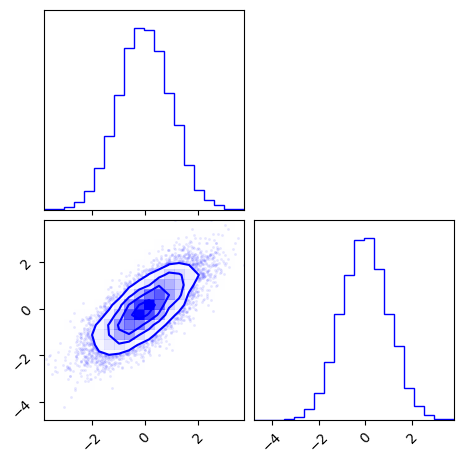

In [5]:
import corner
from scipy.stats import multivariate_normal

# load multivariate normal distribution
mean = np.array([0.,0.])
cov = np.array([[1.,0.75], [0.75, 1.]])
samples = multivariate_normal(mean=mean, cov=cov, allow_singular=False).rvs(size = 10000)
figure = corner.corner(samples, color = 'b')

##### Cholesky Decomposition
Instead of letting our hyperparameters be the positive-definite, symmetric covariance matrix $\Sigma$. We found it easier to let the hyperparameters be the *cholesky decomposition* of the covariance matrix. It is a lower-triangular matrix $L$ defined so that
$$ \Sigma = L \cdot L^{T}. $$
This expression leads us to the fact that $L$ is the generalization of the *square-root* for matrices. This choice allows our fitter to search over positive-definite matrices. 

In [6]:
# cholesky decomposition
from numpy.linalg import cholesky
L = cholesky(cov)
print('Covariance Matrix from Cholesky: ', L @ L.T)

Covariance Matrix from Cholesky:  [[1.   0.75]
 [0.75 1.  ]]


In [7]:
# helper functions for converting between array and triangular matrix

## convert lower triangular matrix to an flat array
def tril_to_arr(tril):
    arr = tril.reshape(-1)
    is_nonzero = np.where(arr != 0)[0]
    return arr[is_nonzero]

## convert flat array to lower triangular matrix
def arr_to_tril(s, ndim):
    tril_idx = np.tril_indices(ndim)
    tril = np.zeros([ndim, ndim])
    tril[tril_idx] = s
    return tril

# helper function for initializing the covariance matrix
def init_s(ndim):
    proto = 0.1 * np.ones([ndim, ndim])
    for i in range(ndim): proto[i,i] = 1
    tril = np.tril(proto)
    return tril_to_arr(tril)

In [8]:
# sample-average version of objective fn
def objective_fn(x, args):
    num_samples, ndim = np.array(args[-2:], dtype = int) # number of samples for kl approx, number of dimensions
    mu_q = args[:ndim] ; s_q = args[ndim:-2] # mu, sigma of target distribution
    mu_p = x[:ndim] ; s_p = x[ndim:] # mu, sigma of fit distribution
    L_p = arr_to_tril(s_p, ndim) ; cov_p = L_p @ L_p.T
    L_q = arr_to_tril(s_q, ndim) ; cov_q = L_q @ L_q.T
    q_samples = multivariate_normal.rvs(mean=mu_q, cov=cov_q, size=num_samples)
    return np.mean(
        multivariate_normal.logpdf(q_samples, mean=mu_q, cov=cov_q) - 
        multivariate_normal.logpdf(q_samples, mean=mu_p, cov=cov_p))

# number of samples and dimensions
num_samples = 10000
ndim = 2

# target mean and covariance
mu_q = np.array([3., 2.])
s_q = tril_to_arr(L)
args = np.concatenate((mu_q, s_q, [num_samples], [ndim]))

# initial guess for mean and covariance
mu0 = np.array([0., 0.])
s0 = init_s(ndim)
x0 = np.concatenate((mu0, s0))

In [9]:
# perform fit
res = minimize(objective_fn, x0, args = args, method = 'Powell', 
               options = {
                   'maxiter' : 1000,
                   'maxfev' : 1000,
                   'ftol' : 1e-10,
                   'disp' : True},
              )
res # print results

Optimization terminated successfully.
         Current function value: 0.000756
         Iterations: 3
         Function evaluations: 298


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.0007557099727757998
       x: [ 3.030e+00  2.014e+00  9.802e-01  7.633e-01  6.585e-01]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 298

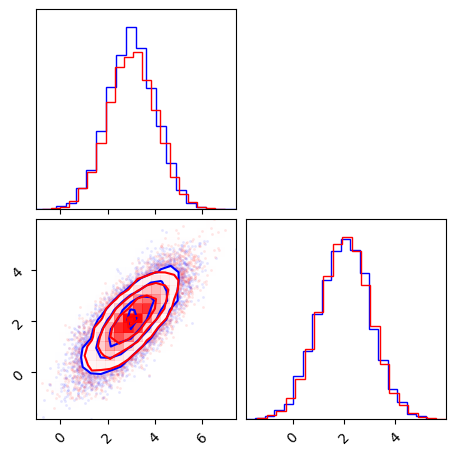

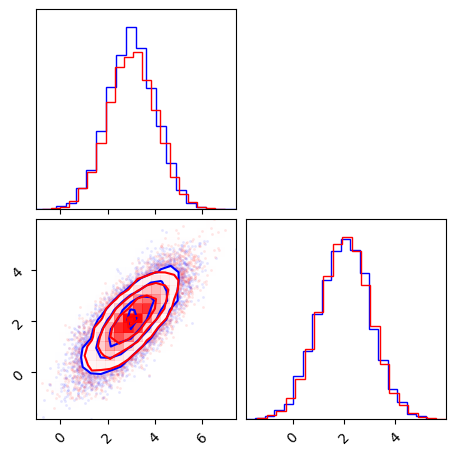

In [10]:
# plot the target and best-fit distributions
## Note: In VSCode, two plots are being produced. In Jupyter, only one plot is produced.
cov_q = cov
samples_q = multivariate_normal(mean=mu_q, cov=cov_q, allow_singular=False).rvs(size = 10000)

mu_opt = res.x[:ndim]
s_opt = res.x[ndim:] 
L_opt = arr_to_tril(s_opt,ndim) ; cov_opt = L @ L.T
samples_p = multivariate_normal(mean=mu_opt, cov=cov_opt, allow_singular=False).rvs(size = 10000)

fig = corner.corner(samples_q, color = 'b')
corner.corner(samples_p, fig=fig, color = 'r')

#### 5D Multivariate Gaussians

In [11]:
# create a positive-definite matrix from cholesky decomposition of a random matrix
m = 2. * np.random.random(size= [5,5]) - 1.
cov = m @ m.T
L = cholesky(cov)

In [12]:
# number of samples and dimensions
num_samples = 10000
ndim = 5

# target mean and covariance
mu_q = np.array([3., 2., -4., 0., -2.])
s_q = tril_to_arr(L)
args = np.concatenate((mu_q, s_q, [num_samples], [ndim]))

# initial guess for mean and covariance
mu0 = np.array([0., 0., 0., 0., 0.])
s0 = init_s(ndim)
x0 = np.concatenate((mu0, s0))

In [13]:
# perform fit
res = minimize(objective_fn, x0, args = args, method = 'Powell', 
               options = {
                   'maxiter' : 10000,
                   'maxfev' : 10000,
                   'ftol' : 1e-10,
                   'disp' : True},
              )
res # print results

Optimization terminated successfully.
         Current function value: 0.048045
         Iterations: 7
         Function evaluations: 2596


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.04804480947002305
       x: [ 2.707e+00  2.416e+00 ...  5.643e-01  8.577e-01]
     nit: 7
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 2596

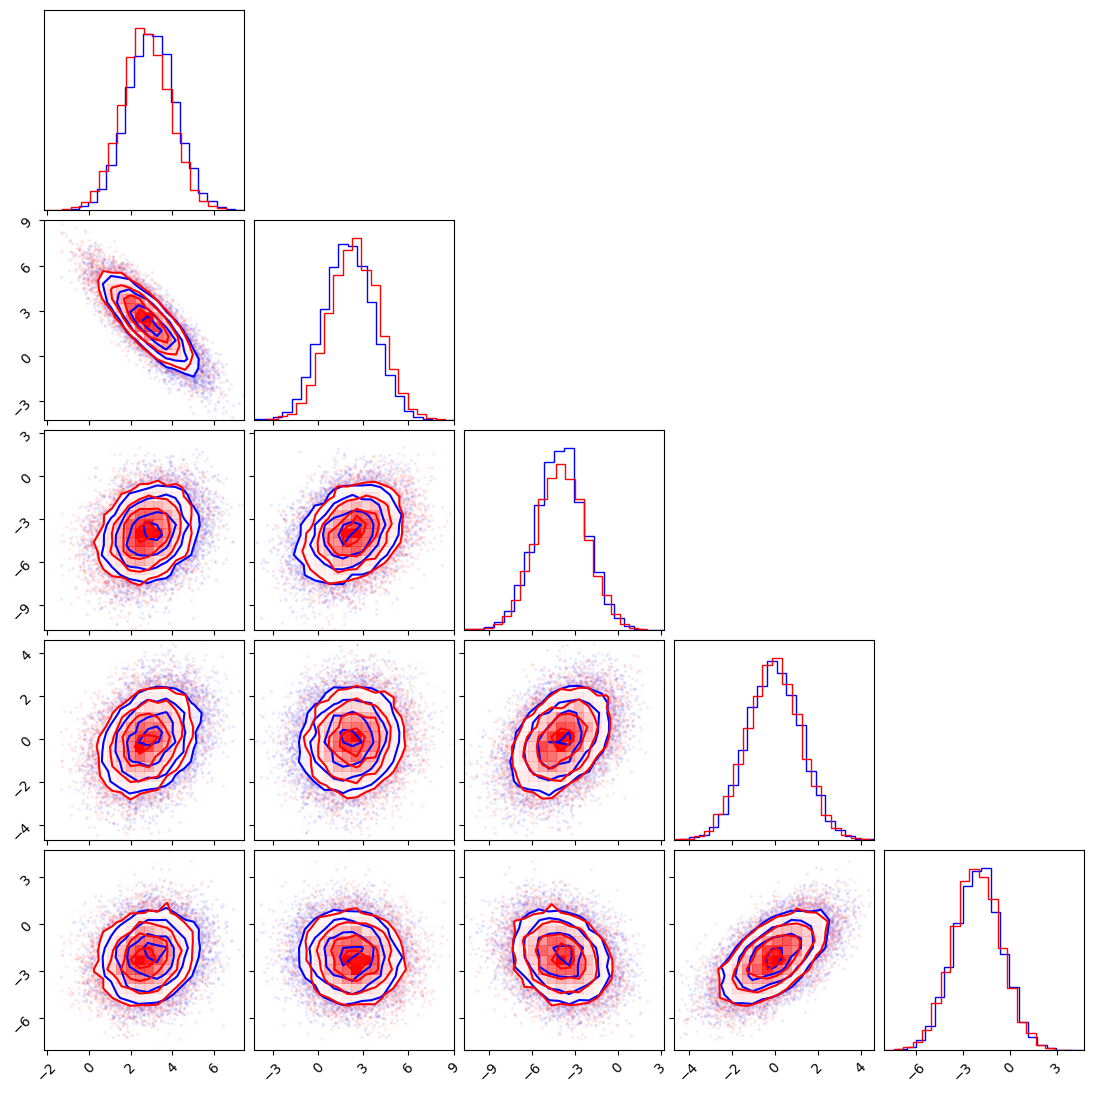

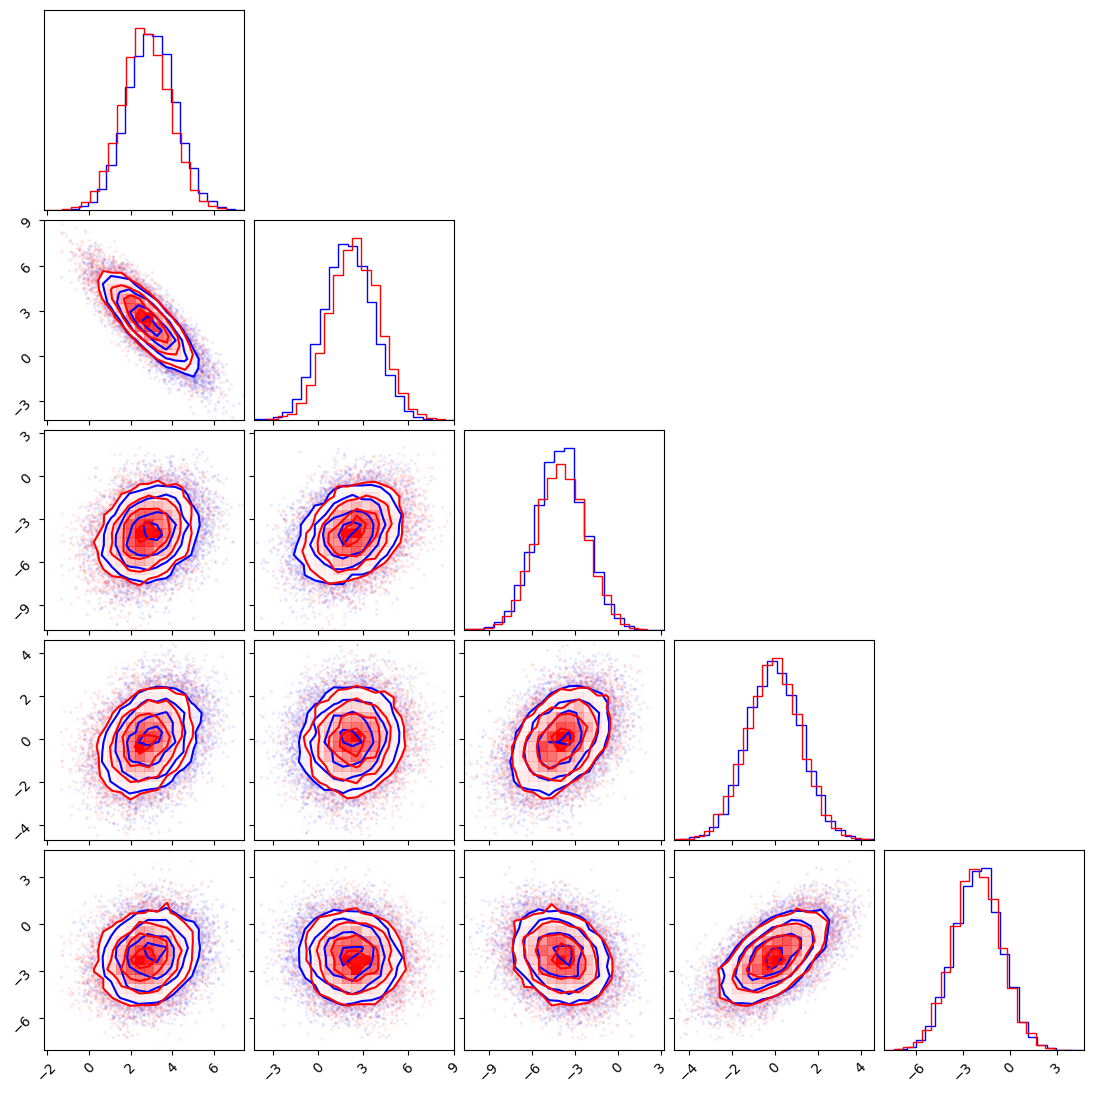

In [14]:
# plot the target and best-fit distributions
## Note: In VSCode, two plots are being produced. In Jupyter, only one plot is produced.
cov_q = cov
samples_q = multivariate_normal(mean=mu_q, cov=cov_q, allow_singular=False).rvs(size = 10000)

mu_opt = res.x[:ndim]
s_opt = res.x[ndim:] 
L_opt = arr_to_tril(s_opt,ndim) ; cov_opt = L @ L.T
samples_p = multivariate_normal(mean=mu_opt, cov=cov_opt, allow_singular=False).rvs(size = 10000)

fig = corner.corner(samples_q, color = 'b')
corner.corner(samples_p, fig=fig, color = 'r')

## Appendix: Maximum Likelihood Estimation and KL-Divergence Minimization

Using maximum likelihood estimation for regression always rubbed me the wrong way. How does maximizing the likelihood get you closer to the truth? At face value, all maximizing the likelihood guarantees is that your observed data has the highest probability density of all outcomes in your model, not even the highest probability. The KL-divergence is the key to proving that MLE takes you closer to the true model.

**Def:** The KL-divergence between a distributions $p(x)$ and $q(x)$ is given by

$$
D_{KL} (p||q) \equiv \sum_{x \in \mathcal{X}} p(x) \ \log \frac{p(x)}{q(x)} = \mathbb{E}_{x \sim p(x)}\left [\log \frac{p(x)}{q(x)} \right ]
$$

Note that this is really just the entropy difference between $p$ and $q$. Take $p$ to denote the true distribution and $q$ to denote an estimate. With the intuition that entropy must always be maximized, any $q(x) \neq p(x)$ corresponds to lesser entropy, and so, the minimum entropy difference corresponds to $p(x) = q(x).$

**Theorem:** Take $p(x) \rightarrow p(x|\theta^{*})=p$ and $q(x) \rightarrow p(x|\theta)=p_{\theta}$, where $\theta$ denotes distribution parameters and $\theta^{*}$ maximizes the log-likelihood corresponding to data $\{x_{i}\}_{i=1}^{N}$. That is, 

$$
\theta^{*} = -\argmin_{\theta} \sum_{i} \log p(x_{i}|\theta).
$$

Then, for $N \rightarrow \infty$,

$$
\theta^{*} = \argmin_{\theta} D_{KL}(p||p_{\theta}).
$$

**Proof:** We start from the KL-divergence:

$$
D_{KL}(p||p_{\theta}) = \mathbb{E}_{x \sim p(x|\theta^{*})}\left [\log p(x|\theta^{*})] - \mathbb{E}_{x \sim p(x|\theta^{*})}  [\log p(x|\theta)] \right ] 
$$

Since the first term is independent of $\theta$, it does not affect minimization. So,

$$
\argmin_{\theta} D_{KL}(p||p_{\theta}) = - \argmin_{\theta} \mathbb{E}_{x \sim p(x|\theta^{*})}  [\log p(x|\theta)],  \\ 
$$

where we can compute the expectation value by a Monte Carlo estimate:

$$
\mathbb{E}_{x \sim p(x|\theta^{*})}  [\log p(x|\theta)] \sim \frac{1}{N} \sum_{i} \log p(x_{i}|\theta)
$$

Therefore, 

$$
\begin{aligned}
\argmin_{\theta} D_{KL}(p||p_{\theta}) & \sim - \argmin_{\theta}  \frac{1}{N} \sum_{i} \log p(x_{i}|\theta) \\ 
& = -\argmin_{\theta}   \sum_{i} \log p(x_{i}|\theta) \\
& = \theta^{*}.
\end{aligned}
$$